# Posterior Network: Uncertainty Estimation without OOD Samples via Density-Based Pseudo-Counts

Posterior Networks (PostNet) extend the idea of Evidential Deep Learning by deriving Dirichlet evidence from class-conditional density estimates in a learned latent space. This enables uncertainty to increase for inputs that lie outside the learned data distribution, eliminating the need for explicit out-of-distribution (OOD) samples during training.

In this notebook, we will:
- Define a Posterior Network model consisting of an encoder and a density model
- Convert densities into evidence (Dirichlet pseudo-counts) and train with a unified evidential trainer
- Evaluate accuracy and plot epistemic evidence for in-distribution (ID) and OOD data


## Imports and Setup

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor, nn
from torch.distributions import Dirichlet
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T

from probly.layers.evidential import torch as t
from probly.losses.evidential.torch import postnet_loss
import probly.models.evidential.torch as m
from probly.train.evidential.torch import unified_evidential_train

device = "cuda" if torch.cuda.is_available() else "cpu"

## Data Preparation

Posterior Networks require:
- an ID dataset used for training and standard evaluation
- an OOD dataset used only for testing epistemic uncertainty

Here, we use **MNIST** as the ID dataset and **FashionMNIST** as the OOD dataset

In [2]:
transform = T.transforms.Compose(
    [
        T.transforms.ToTensor(),
        T.transforms.Normalize((0.5,), (0.5,)),
    ],
)

train_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=True,
    download=True,
    transform=transform,
)
test_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)
ood_data = torchvision.datasets.FashionMNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)
ood_loader = DataLoader(ood_data, batch_size=256, shuffle=False)

print("Loaded MNIST (ID) and FashionMNIST (OOD)")

Loaded MNIST (ID) and FashionMNIST (OOD)


## Model Definition

### Posterior Networks are composed of:

#### 1. Encoder
The encoder maps each input to a low-dimensional latent vector. A simple MLP-based encoder that flattens MNIST images is used here.


In [5]:
# MLP Encoder using MNIST inputs
class FlattenMLPEncoder(nn.Module):
    """Flatten + MLP encoder that maps an input tensor to a latent vector z."""

    def __init__(self, input_dim: int = 784, hidden_dim: int = 256, latent_dim: int = 6) -> None:
        """Initialize the encoder.

        Args:
            input_dim: number of input features after flattening.
            hidden_dim: width of the hidden layer.
            latent_dim: Dimension of the output latent representation.
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Compute latent vector z.

        Args:
            x: Input tensor of shape (B, ...) where B is batch size

        Returns:
            Latent tensor of shape (B, latent_dim).
        """
        return self.net(x)

#### 2. Class-conditional density model
A radial-flow-based density estimator that computes class-conditional densities P(z|c) in the latent space. These density estimates are used to derive Dirichlet evidence for uncertainty-aware predictions.

In [ ]:
class RadialFlowLayer(nn.Module):
    """Single radial flow transformation shared across all classes."""

    def __init__(self, num_classes: int, dim: int) -> None:
        """Initialize parameters for a radial flow transform."""
        super().__init__()
        self.c = num_classes
        self.dim = dim

        self.x0 = nn.Parameter(torch.zeros(self.c, self.dim))
        self.alpha_prime = nn.Parameter(torch.zeros(self.c))
        self.beta_prime = nn.Parameter(torch.zeros(self.c))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Reset learnable parameters with a small uniform init."""
        stdv = 1.0 / math.sqrt(self.dim)
        self.x0.data.uniform_(-stdv, stdv)
        self.alpha_prime.data.uniform_(-stdv, stdv)
        self.beta_prime.data.uniform_(-stdv, stdv)

    def forward(self, zc) -> tuple[torch.Tensor, torch.Tensor]:  # noqa: ANN001
        """Apply the radial flow to latent inputs zc."""
        alpha = torch.nn.functional.softplus(self.alpha_prime)
        beta = -alpha + torch.nn.functional.softplus(self.beta_prime)

        x0 = self.x0.unsqueeze(1)
        diff = zc - x0
        r = diff.norm(dim=-1)

        h = 1.0 / (alpha.unsqueeze(1) + r)
        h_prime = -h * h
        beta_h = beta.unsqueeze(1) * h

        z_new = zc + beta_h.unsqueeze(-1) * diff

        term1 = (self.dim - 1) * torch.log1p(beta_h)
        term2 = torch.log1p(beta_h + beta.unsqueeze(1) * h_prime * r)
        log_abs_det = term1 + term2

        return z_new, log_abs_det


class BatchedRadialFlowDensity(nn.Module):
    """Radial-flow density estimator that computes P(z|c) for all classes."""

    def __init__(self, num_classes: int, dim: int, flow_length: int = 6) -> None:
        """Create a sequence of radial flow layers and base distribution."""
        super().__init__()
        self.c = num_classes
        self.dim = dim

        self.layers = nn.ModuleList(
            [RadialFlowLayer(num_classes, dim) for _ in range(flow_length)],
        )

        self.log_base_const = -0.5 * self.dim * math.log(2 * math.pi)

    def forward(self, x) -> tuple[torch.Tensor, torch.Tensor]:  # noqa: ANN001
        """Expand input x for all classes and apply flow layers."""
        B = x.size(0)  # noqa: N806
        zc = x.unsqueeze(0).expand(self.c, B, self.dim)
        sum_log_jac = torch.zeros(self.c, B, device=x.device)

        for layer in self.layers:
            zc, log_j = layer(zc)
            sum_log_jac = sum_log_jac + log_j

        return zc, sum_log_jac

    def log_prob(self, x) -> torch.Tensor:  # noqa: ANN001
        """Return class-conditional log densities log P(x|c)."""
        zc, sum_log_jac = self.forward(x)  # zc: [C,B,D]

        base_logp = self.log_base_const - 0.5 * (zc**2).sum(dim=-1)
        logp = base_logp + sum_log_jac  # [C,B]

        return logp.transpose(0, 1)  # [B,C]

## Full Posterior Network Model

In [ ]:
class PostNetModel(nn.Module):
    """Posterior Network model containing encoder + flow."""

    def __init__(
        self,
        encoder: nn.Module | None = None,
        flow: nn.Module | None = None,
        latent_dim: int = 6,
    ) -> None:
        """Initialize a Posterior Network model."""
        super().__init__()

        if flow is None:
            flow = t.BatchedRadialFlowDensity(num_classes=10, dim=latent_dim, flow_length=6)

        self.encoder = encoder
        self.flow = flow

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Encode inputs into latent representations.

        Args:
            x: Input tensor of shape (B, ...) where B is batch size.

        Returns:
            Latent tensor z of shape (B, latent_dim).
        """
        return self.encoder(x)

## PostNet Loss Function

Posterior Networks are trained using a Bayesian evidential loss that optimizes a Dirichlet distribution over class probabilities.
The loss consists of two components:
1. an expected cross-entropy term, which encourages correct class predictions
2. an entropy regularization term, which promotes well-calibrated uncertainty estimates

The Dirichlet parameters are constructed from class-conditional density estimates in latent space and are scaled by the number of training samples per class.

In [ ]:
def postnet_loss2(
    z: Tensor,
    y: Tensor,
    flow: t.BatchedRadialFlowDensity,
    class_counts: Tensor,
    entropy_weight: float = 1e-5,
) -> torch.Tensor:
    """Posterior Networks (PostNet) loss."""
    log_dens = flow.log_prob(z)  # [B,C]
    dens = log_dens.exp()

    beta = dens * class_counts.unsqueeze(0)
    alpha = beta + 1.0
    alpha0 = alpha.sum(dim=1)

    digamma = torch.digamma
    batch_idx = torch.arange(len(y), device=y.device)
    expected_ce = digamma(alpha0) - digamma(alpha[batch_idx, y])

    entropy = Dirichlet(alpha).entropy()

    loss = (expected_ce - entropy_weight * entropy).mean()
    return loss, alpha

## Training loop using Unified Evidential Train

To train our model, we first compute the number of training samples per class.
These class counts are used to scale the class-conditional density estimates and sure that the resulting Dirichlet parameters reflect the empirical class frequencies.

We then instantiate the encoder and the Posterior Network model and train it using the unified evidential training function with the PostNet loss.

In [6]:
num_classes = 10
class_counts = torch.zeros(num_classes, device=device)

# Count how many samples belong to each class in the training set
for _, y in train_loader:
    y = y.to(device)  # noqa: PLW2901
    for c in range(num_classes):
        class_counts[c] += (y == c).sum()

enc = FlattenMLPEncoder(input_dim=784, hidden_dim=256, latent_dim=6).to(device)
model = m.PostNetModel(encoder=enc)
loss = postnet_loss

unified_evidential_train(
    "PostNet",
    model,
    train_loader,
    loss,
    class_count=class_counts,
    epochs=5,
    lr=1e-3,
)

Epoch [1/5] - Loss: 1.7889
Epoch [2/5] - Loss: 0.4926
Epoch [3/5] - Loss: 0.2507
Epoch [4/5] - Loss: 0.1866
Epoch [5/5] - Loss: 0.1514


## ID Data Evaluation

We evaluate classification accuracy on in-distribution test data using the mean of the predicted Dirichlet distribution.

In [8]:
def evaluate(model, loader, class_counts) -> float:  # noqa: ANN001
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)  # noqa: PLW2901
            z = model(x)

            flow = model.flow
            log_dens = flow.log_prob(z)
            dens = log_dens.exp()
            beta = dens * class_counts.unsqueeze(0)
            alpha = beta + 1.0
            alpha0 = alpha.sum(dim=1, keepdim=True)

            probs = alpha / alpha0
            preds = probs.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += len(y)

    acc = correct / total
    print(f"Accuracy: {acc:.4f}")
    return acc


evaluate(model, test_loader, class_counts)

Accuracy: 0.9622


0.9622

## OOD Data Evaluation

We evaluate epistemic uncertainty by comparing the total Dirichlet evidence for in-distribution (ID) and out-of-distribution (OOD) inputs.
The total evidence is obtained by summing the Dirichlet parameters across classes and serves as a scalar measure of model confidence.

In-distribution samples are expected to yield high evidence, while out-of-distribution inputs should result in low evidence, indicating increased epistemic uncertainty.
We visualize the distributions of total Dirichlet evidence for ID and OOD data to highlight this separation.

Mean ID α₀: 96977.1171875
Mean OOD α₀: 8505.796875


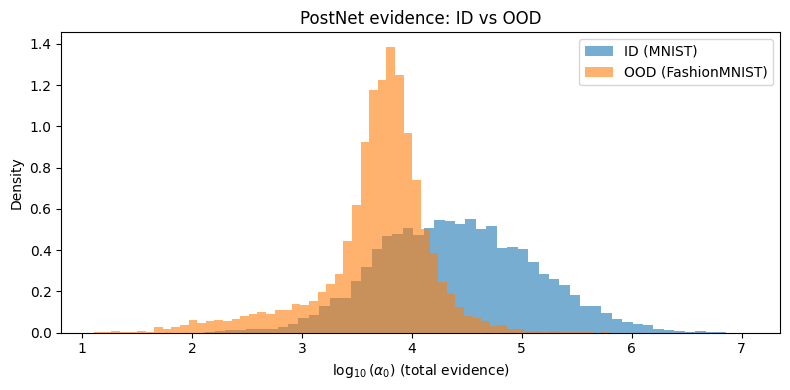

In [9]:
def compute_alpha0(model, loader, class_counts) -> torch.Tensor:  # noqa: ANN001
    model.eval()

    out = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)  # noqa: PLW2901
            z = model(x)
            flow = model.flow
            log_dens = flow.log_prob(z)
            dens = log_dens.exp()
            beta = dens * class_counts.unsqueeze(0)
            alpha = beta + 1.0
            alpha0 = alpha.sum(dim=1)
            out.append(alpha0.cpu())
    return torch.cat(out)


id_alpha0 = compute_alpha0(model, test_loader, class_counts)
ood_alpha0 = compute_alpha0(model, ood_loader, class_counts)

print("Mean ID α₀:", id_alpha0.mean().item())
print("Mean OOD α₀:", ood_alpha0.mean().item())

eps = 1e-12
id_log = np.log10(id_alpha0.numpy() + eps)
ood_log = np.log10(ood_alpha0.numpy() + eps)

plt.figure(figsize=(8, 4))
plt.hist(id_log, bins=60, density=True, alpha=0.6, label="ID (MNIST)")
plt.hist(ood_log, bins=60, density=True, alpha=0.6, label="OOD (FashionMNIST)")
plt.xlabel(r"$\log_{10}(\alpha_0)$ (total evidence)")
plt.ylabel("Density")
plt.title("PostNet evidence: ID vs OOD")
plt.legend()
plt.tight_layout()
plt.show()